# 1.Setup

In [68]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
print(tf.__version__)

2.3.0


# 2.数据加载、探索、分割

## 2.1 数据加载

In [40]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
data = pd.read_csv(file_url)

## 2.2 数据探索

In [41]:
print("-" * 20)
print("data shape:")
print("-" * 20)
data.shape

print("-" * 20)
print("data.head():")
print("-" * 20)
data.head()

--------------------
data shape:
--------------------


(303, 14)

--------------------
data.head():
--------------------


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


## 2.3 数据分割

In [42]:
validation_data = data.sample(frac = 0.2, random_state = 1337)
train_data = data.drop(validation_data.index)
print(f"number training dataset samples:{train_data.shape[0]}")
print(f"number validation dataset samples:{validation_data.shape[0]}")

number training dataset samples:242
number validation dataset samples:61


## 2.4 数据集生成

In [69]:
def dataframe_to_dataset(dataframe, batch_size):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices(
        (
            dict(dataframe), 
            labels
        )
    )
    # shuffle
    ds = ds.shuffle(buffer_size = len(dataframe))
    # batch_size
    ds = ds.batch(batch_size)
    return ds

In [71]:
train_ds = dataframe_to_dataset(train_data, batch_size = 32)
validation_ds = dataframe_to_dataset(validation_data, batch_size = 32)

In [76]:
# for x, y in train_ds.take(1):
#     print("Input:", x)
#     print("Target:", y)

# 3.Keras 特征处理

## 3.1 字符特征编码

In [51]:
def encode_string_categorical_feature(feature, name, dataset):
    """
    字符特征编码
    """
    # (1)Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    # (2)创建 StringLookup 层，字符串编码
    index = StringLookup()
    index.adapt(feature_ds)
    encoded_feature = index(feature) # 将字符串编码为整数
    
    # (3)创建 CategoryEncoding 层，整数编码
    feature_ds = feature_ds.map(index)
    encoder = CategoryEncoding(output_mode = "binary")
    encoder.adapt(feature_ds)
    encoded_feature = encoder(encoded_feature) # one-hot encode
    return encoded_feature

## 3.2 整数特征编码

In [47]:
def encode_integer_categorical_feature(feature, name, dataset):
    """
    整数特征编码
    """
    # (1)Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # (2)创建 CategoryEncoding 层
    encoder = CategoryEncoding(output_mode = "binary")
    encoder.adapt(feature_ds)
    encoded_feature = encoder(feature)
    return encoded_feature

## 3.3 连续特征标准化

In [48]:
def encode_numerical_feature(feature, name, dataset):
    """
    数值特征标准化
    """
    # (1)Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # (2)
    normalizer = Normalization()
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

## 3.4 特征处理

In [ ]:
def get_input_encoded_features(CATEGORICAL_FEATURES, STRING_FEATURES, NUMERICAL_FEATURES):
    all_inputs = []
    all_features = []
    for feature_name in CATEGORICAL_FEATURES:
        feature = keras.Input(shape = (1,), name = f"{feature_name}", dtype = "int64")
        all_inputs.append(feature)
        feature_encoded = encode_integer_categorical_feature(feature, f"{feature_name}", train_ds)
        all_features.append(feature_encoded)
    
    for feature_name in STRING_FEATURES:
        feature = keras.Input(shape = (1,), name = f"{feature_name}", dtype = "string")
        all_inputs.append(feature)
        feature_encoded = encode_string_categorical_feature(feature, f"{feature_name}", train_ds)
        all_features.append(feature_encoded)
        
    for feature_name in NUMERICAL_FEATURES:
        feature = keras.Input(shape = (1,), name = f"{feature_name}")
        all_inputs.append(feature)
        feature_encoded = encode_numerical_feature(feature, f"{feature_name}", train_ds)
        all_features.append(feature_encoded)
    
    return all_inputs, all_features

# 4.构建模型

## 4.1 构建模型

In [80]:
def get_model(all_inputs, all_features):
    all_features = layers.concatenate(all_features)
    x = layers.Dense(32, activation = "relu")(all_features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation = "sigmoid")(x)
    model = keras.Model(all_inputs, output)
    return model

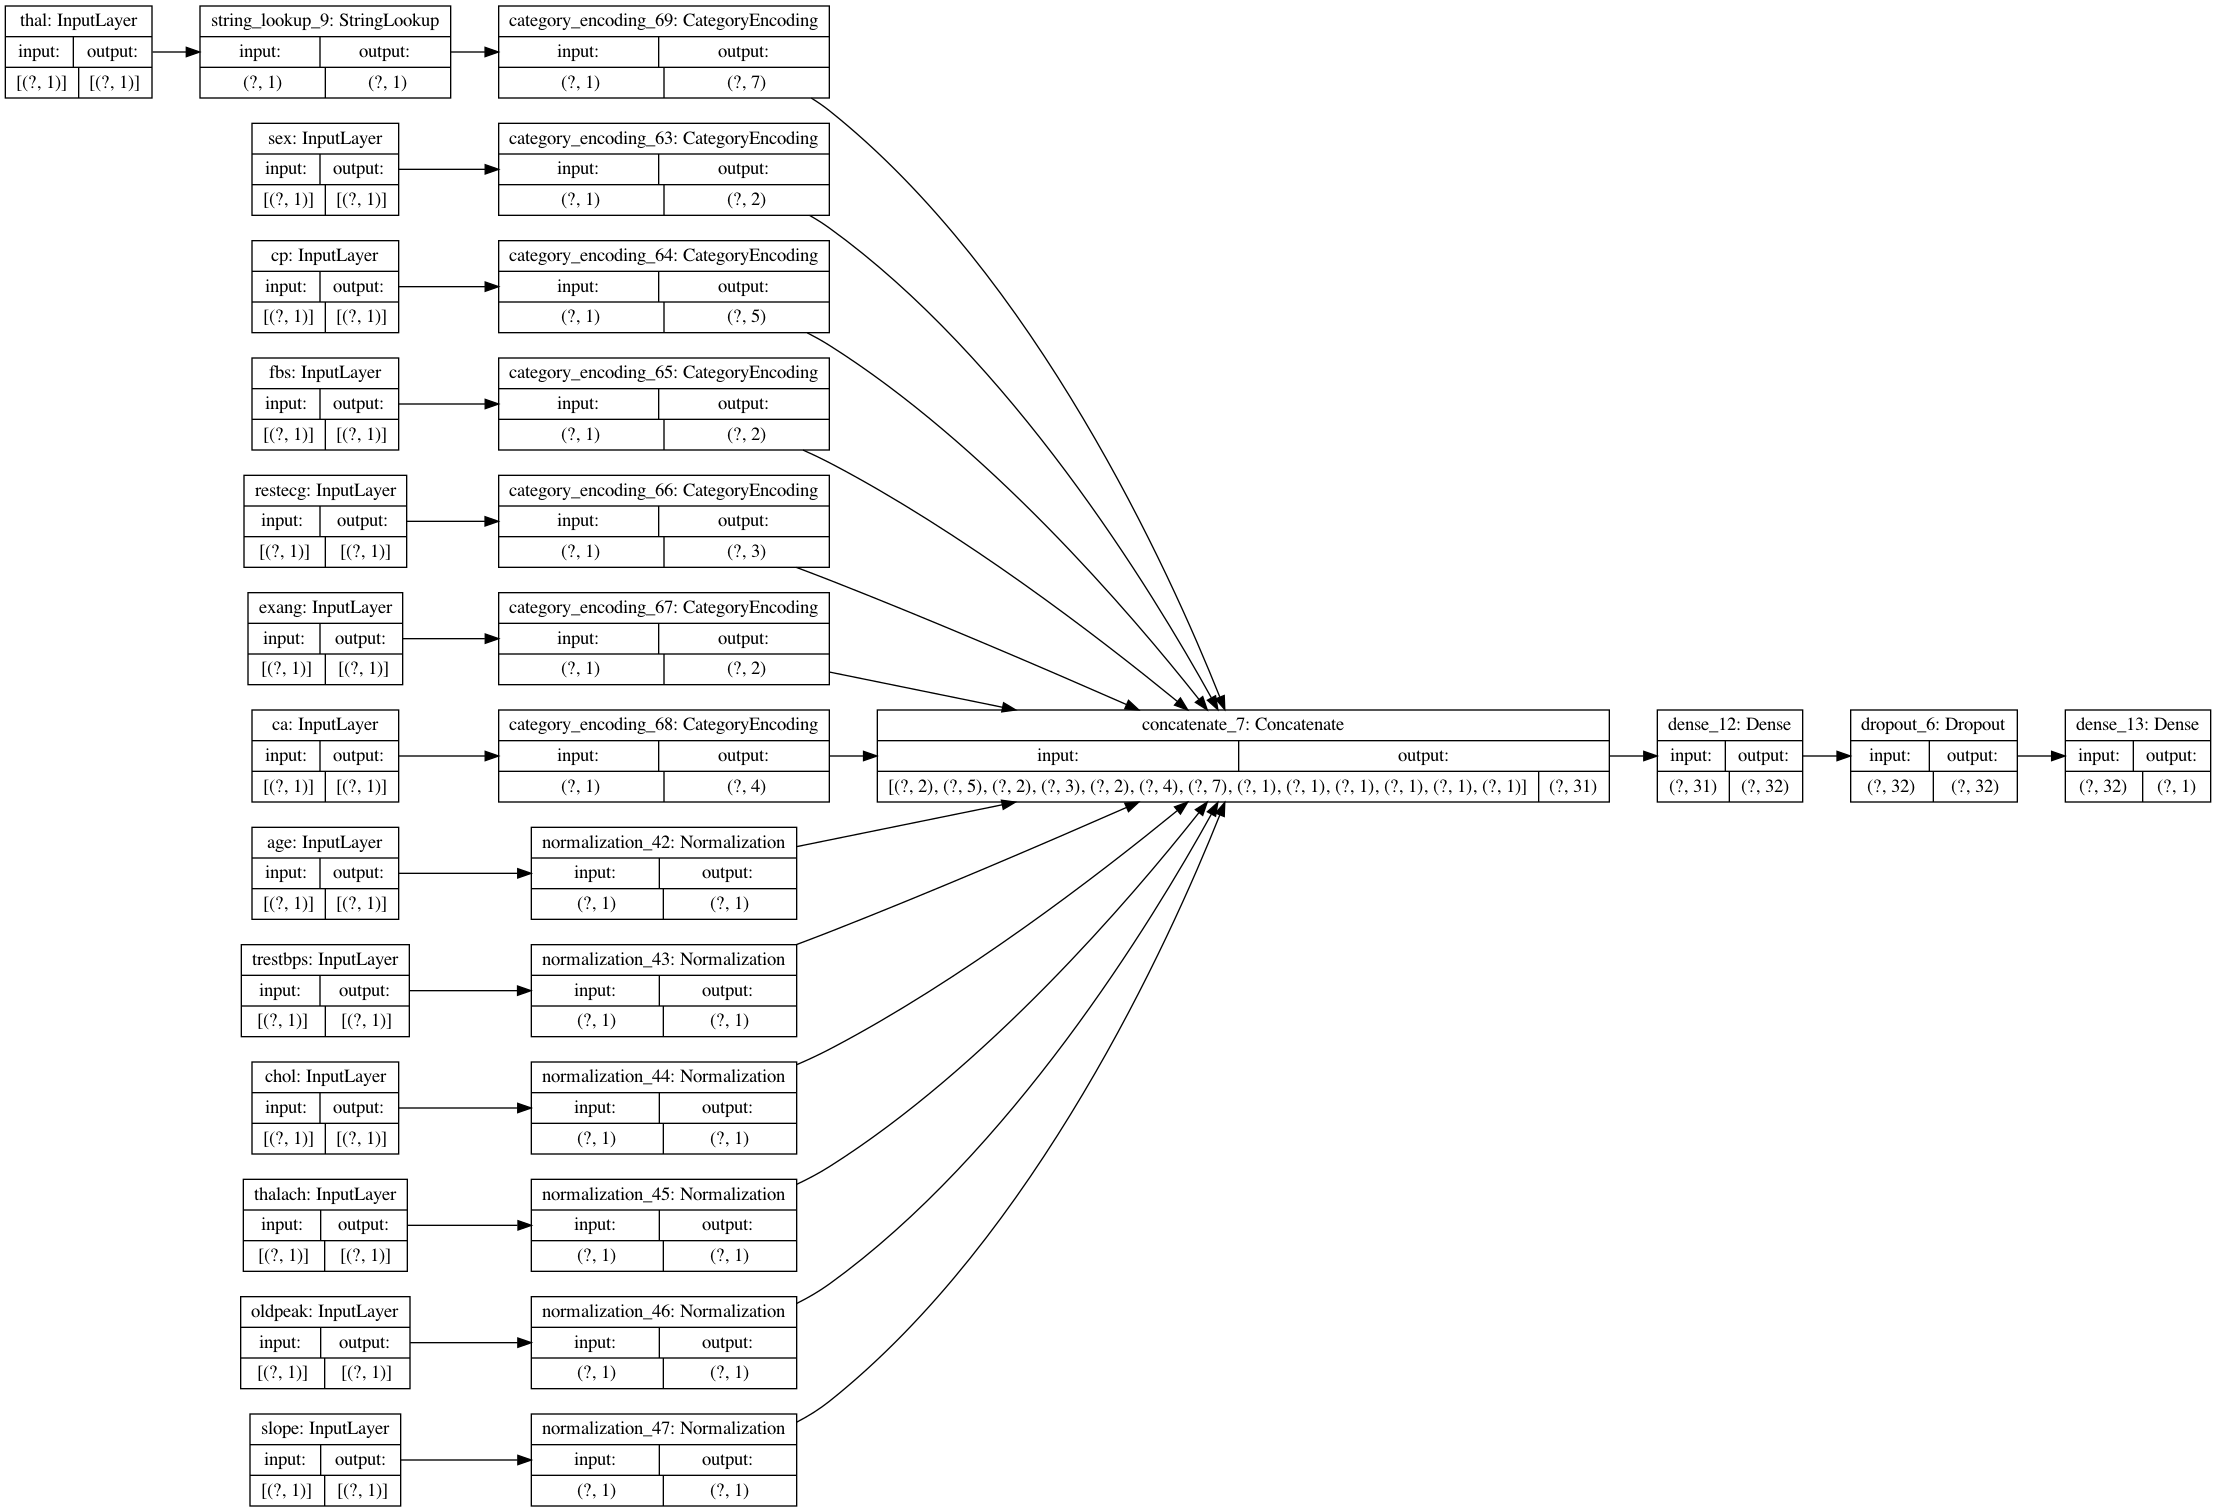

In [81]:
all_inputs, all_features = get_input_encoded_features(
    CATEGORICAL_FEATURES = [
        "sex",
        "cp",
        "fbs",
        "restecg",
        "exang",
        "ca",
    ],
    STRING_FEATURES = ["thal"],
    NUMERICAL_FEATURES = [
        "age",
        "trestbps",
        "chol",
        "thalach",
        "oldpeak",
        "slope",
    ],
)
model = get_model(all_inputs, all_features)
keras.utils.plot_model(model, show_shapes = True, rankdir = "LR")

## 4.2 模型编译、训练

In [74]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.fit(train_ds, epochs = 50, validation_data = validation_ds)

Epoch 1/50
8/8 [==============================] - 0s 27ms/step - loss: 0.7743 - accuracy: 0.5331 - val_loss: 0.6229 - val_accuracy: 0.7377
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.6281 - val_loss: 0.5795 - val_accuracy: 0.7541
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6653 - val_loss: 0.5427 - val_accuracy: 0.7869
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6570 - val_loss: 0.5104 - val_accuracy: 0.7869
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5755 - accuracy: 0.7066 - val_loss: 0.4831 - val_accuracy: 0.7705
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5580 - accuracy: 0.7273 - val_loss: 0.4614 - val_accuracy: 0.7869
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7438 - val_loss: 0.4446 - val_accuracy: 0.8033
Epoch 8/50
8/8 [=================

# 5.模型评估

In [75]:
new_sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}
input_dict = {
    name: tf.convert_to_tensor([value]) for name, value in new_sample.items()
}
predictions = model.predict(input_dict)
print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 26.9 percent probability of having a heart disease, as evaluated by our model.
